##*Disaster Tweets Classification*

By Nakshatra Singh 

This notebook will show you how to build a Disaster Tweet classification model using Tfidf, SVM and BERT.

##Using Google GPU for Training

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected.

In [1]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!') 

Found GPU at : /device:GPU:0


###**1. Imports**

In [2]:
import numpy as np
import pandas as pd

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###**2. Retrieve and Inspect Dataset** 

Let's download the dataset which is uploaded on my google drive.

In [3]:
!gdown --id 1TQ0H82EVLZPvf9h1InU47hpe2_6pjX1W 

Downloading...
From: https://drive.google.com/uc?id=1TQ0H82EVLZPvf9h1InU47hpe2_6pjX1W
To: /content/train.csv
100% 996k/996k [00:00<00:00, 67.2MB/s]


We'll use `pandas` to parse the csv files. 

In [4]:
tweet = pd.read_csv('/content/train.csv') 

Let's take a look at the first few rows of the table just to see what's in there. 

In [5]:
tweet.head() 

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
tweet.shape

(7613, 5)

In [7]:
tweet.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Does the dataset contain null values?


In [8]:
tweet.isnull().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The dataset contains a few null values, but we are only interested in text and target column. So we are good to go.

Let's set up the matplotlib params for plotting consistent and clean plots.

In [9]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 80 

In [10]:
plt.style.use('ggplot') 

###**3. Exploratory Data Analysis**

### 3.1 Target Class Distribution

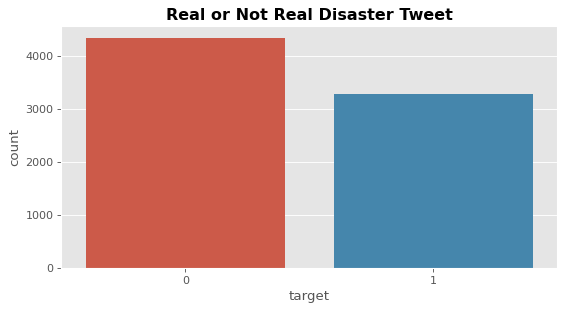

In [11]:
sns.countplot('target', data = tweet)
plt.title('Real or Not Real Disaster Tweet', fontweight='bold');

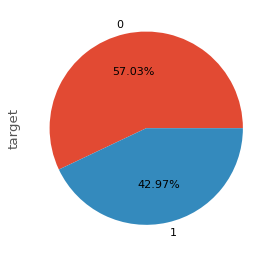

In [12]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%'); 

### 3.2 Character Count Distribution

For other features, we'll use my text preprocessing package which is uploaded on my github [repository](https://github.com/nakshatrasinghh/Preprocess_Nakshatra/).

In [13]:
!pip install git+https://github.com/nakshatrasinghh/Preprocess_Nakshatra.git 

  Cloning https://github.com/nakshatrasinghh/Preprocess_Nakshatra.git to /tmp/pip-req-build-w8_hzax6
  Running command git clone -q https://github.com/nakshatrasinghh/Preprocess_Nakshatra.git /tmp/pip-req-build-w8_hzax6
  Created wheel for Preprocess-Nakshatra: filename=Preprocess_Nakshatra-0.0.5-cp36-none-any.whl size=5603 sha256=0333bc19d8925ee856e8ce0984b5c77a885034122c61e273a224b30b20178f2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmfeqnx1/wheels/7c/40/7e/506590ed754a94a7d77c429bda69f1fb4a260a7d5905403d03
Successfully built Preprocess-Nakshatra


Let's import my package, please make sure to check it out :)

In [14]:
import Preprocess_Nakshatra as pn

I have written a method in my package which will give us basic features for each row in our dataframe. 

In [15]:
tweet = pn.get_basic_features(tweet) 

Now, let's see how our dataset looks likes.

In [16]:
tweet.head() 

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


Let's take a look at the Distribution Plot of character counts.

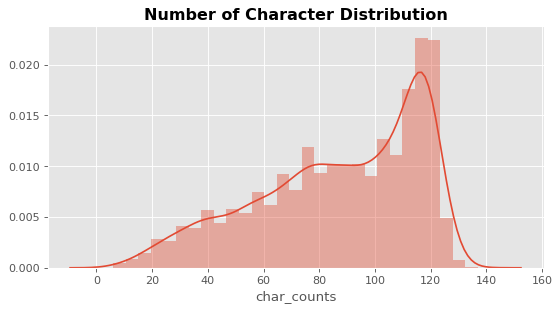

In [17]:
sns.distplot(tweet['char_counts'])
plt.title('Number of Character Distribution', fontweight='bold');

Kernel Density Estimation plot, without histogram in displot

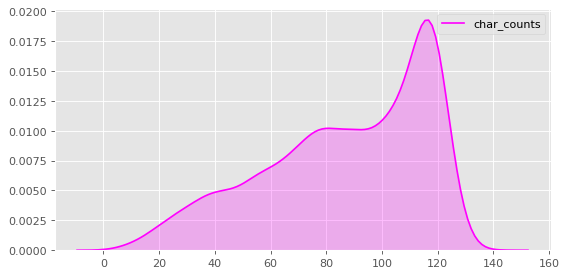

In [18]:
sns.kdeplot(tweet['char_counts'], shade=True, color='magenta');

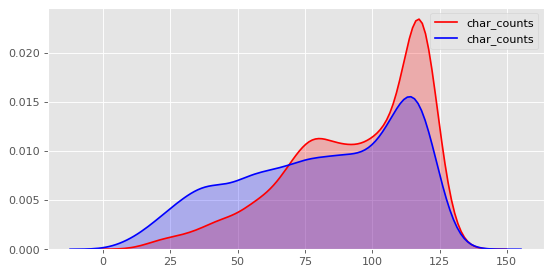

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red'); #disaster
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue'); #no disaster

This plot shows KDE for word length concentrations at different values, for target==1 it is more concentrated around 120 and this makes sense as the user wants to express feelings and emotions which happened in that disaster.

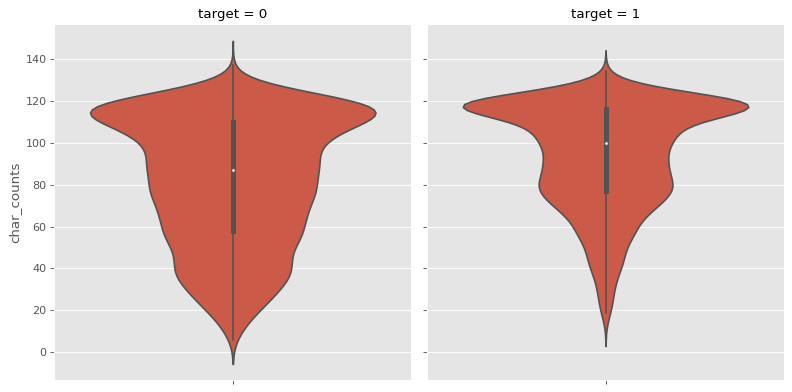

In [20]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target');

### 3.3 Number of words, Average Word Length and Stop word Distribution in Tweets

KDE plot for Word counts

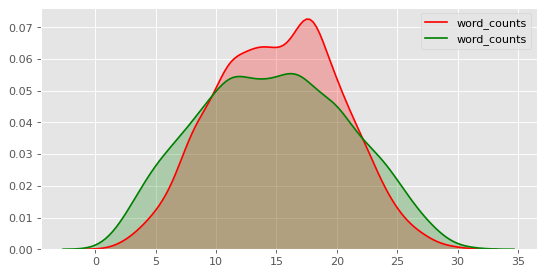

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red') #disaster
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='green'); #no disaster 

For target==0, the concentration is fat, this maybe because the tweets are small and don't vibrate any information regarding a disaster occurance.

KDE plot for Average word length

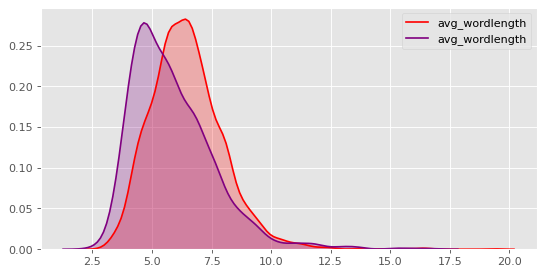

In [22]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red') #disaster
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='purple'); #no disaster 

KDE plot for Stopword counts

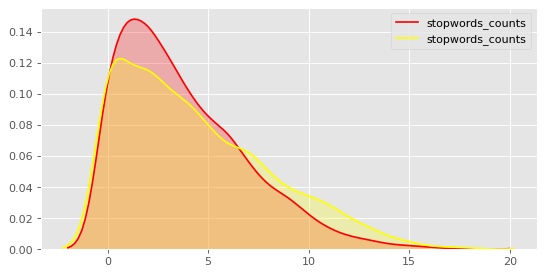

In [23]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red') #disaster
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='yellow'); #no disaster  

For target==1, the stopword counts is high as the user is willing to  deliver maximum information and use less unnecessary words.

### 3.4 Most and Least Common Words

In [24]:
freqs = pn.get_value_counts(tweet, 'text') 

Top 20 most occuring words.

In [25]:
top20 = freqs[:20] 

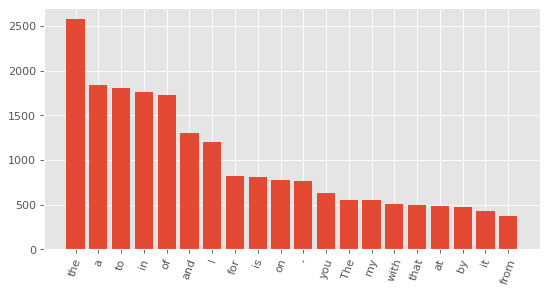

In [26]:
plt.bar(top20.index, top20.values) 
plt.xticks(rotation=70);

Least 20 occuring words.

In [28]:
least20 = freqs[-20:]
least20

Appraisal                 1
america                   1
CDT.                      1
Suffering                 1
DEANS                     1
#VideoGame                1
sara                      1
Buddz                     1
reator                    1
Panther.                  1
#wattys2015'              1
BRUH                      1
community.                1
#boy                      1
http://t.co/ADIp0UnXHU    1
delusions                 1
falling-off-stool         1
A1A                       1
http://t.co/g0dN1ChLUo    1
SpaceX                    1
dtype: int64

This is unique and makes sense because differnet users provide differnt hashtags, words, links and vocubulary.

###**4. One shot Data Cleaning**

A python function which is avaliable in my [python package](https://github.com/nakshatrasinghh/Preprocess_Nakshatra/).

In [30]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = pn.cont_exp(x)
    x = pn.remove_emails(x)
    x = pn.remove_urls(x)
    x = pn.remove_html_tags(x)
    x = pn.remove_rt(x)
    x = pn.remove_mentions(x)
    x = pn.remove_accented_chars(x)
    x = pn.remove_special_chars(x)
    x = pn.remove_dups_char(x)
    return x 

Cleaning Tweet Data with one-shot method. 

In [31]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x)) 

In [32]:
tweet.head()['text'] 

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### **5. WordCloud Visualization**

For real disaster tweets;

In [33]:
real = pn.get_word_freqs(tweet[tweet['target']==1], 'text') 
real = ' '.join(real.index) 
#real

Most occuring (excludes stopwords) words in real disaster tweets.

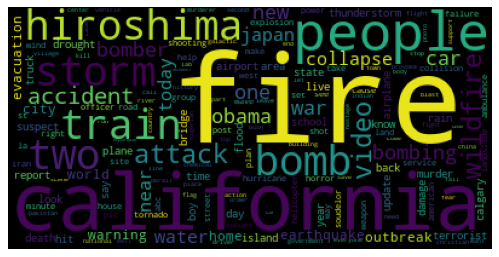

In [34]:
wordcloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(wordcloud)
plt.axis('off');

For non real disaster tweet.

In [35]:
non_real = pn.get_word_freqs(tweet[tweet['target']==0], 'text') 
non_real= ' '.join(non_real.index) 
#non_real

Most occuring (excludes stopwords) words in non real disaster tweets.

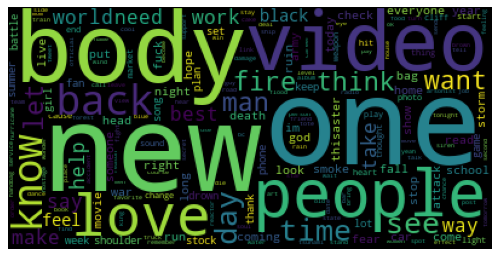

In [36]:
wordcloud = WordCloud(max_font_size=100).generate(non_real)
plt.imshow(wordcloud)
plt.axis('off');

###**6. Classification with Tfidf and SVM**

Let's setup our variables for training the Support Vector Machine.

In [ ]:
text = tweet['text']
y = tweet['target'] 

We will be using Tfidf for creating a 30000 dimensional vector space, since our dataset has around 21k unique words, we should be fine.

In [ ]:
tfidf = TfidfVectorizer(max_features=30000)
X = tfidf.fit_transform(text) 

In [ ]:
X.shape

(7613, 20577)

Spliting our dataframe into training and validation splits, I'll be considering the test data as validation here.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Helper function to run Support Vector Machine directly.

In [ ]:
def run_svm(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report:')
  print(classification_report(y_test, y_pred))

Passing LinearSVC as classifier the classifier.

In [ ]:
clf = LinearSVC() 
run_svm(clf, X_train, X_test, y_train, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.81      0.73      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



We got okay results, this isnt great, but our dataset is relatively small, you surely can try other Machine Learning Algorithms like Random Forest, Decision Trees, XGBoost and Naive bayes.

###**7. BERT Modelling With Ktrain Wrapper**

Let's install the [`ktrain`](https://github.com/amaiya/ktrain) library.

In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 128kB/s 
     |████████████████████████████████| 983kB 39.4MB/s 
     |████████████████████████████████| 245kB 28.7MB/s 
     |████████████████████████████████| 890kB 38.7MB/s 
     |████████████████████████████████| 471kB 45.6MB/s 
     |████████████████████████████████| 890kB 41.2MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
     |████████████████████████████████| 3.0MB 41.5MB/s 
  Created wheel for ktrain: filename=ktrain-0.21.3-cp36-none-any.whl size=25270203 sha256=9b3b6f60ae093fe7ef77a44864204c10258cb676ee0377f8df7e9f19a10b0b82
  Stored in directory: /root/.cache/pip/wheels/d6/ef/6d/9428365b27ac1e84a77214c5718e7f8b2180007af593791247
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=b8fc1a4ee6b8c6982d348a188d23de25c2dd7d6895d1e5355207f976363aa361
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [ ]:
from ktrain import text
import ktrain

Now, let's prepare our data for training it in BERT, I'll use the text from dataframe function present in ktrain.

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df= tweet,
                   text_column='text',
                   label_columns='target',
                   maxlen=40,
                   preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


we'll specify the model as BERT, you can try other models also. Read the project README.md file in the repository.

In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


Just like fit function in Deep Learning Models.

In [ ]:
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)

Just like compile function in Deep Learning Models.

In [ ]:
learner.fit_onecycle(lr=2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 131s 1s/step - loss: 0.5343 - accuracy: 0.7342 - val_loss: 0.4052 - val_accuracy: 0.8294
Epoch 2/3
108/108 [==============================] - 126s 1s/step - loss: 0.3736 - accuracy: 0.8419 - val_loss: 0.3838 - val_accuracy: 0.8346
Epoch 3/3
108/108 [==============================] - 127s 1s/step - loss: 0.2804 - accuracy: 0.8905 - val_loss: 0.4260 - val_accuracy: 0.8150


predictor here is similar to y_pred in machine learning used to display confusion matrix.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

###**8. Predictions on Raw Text**

Let's test our model on our own data.

In [ ]:
data = ['Today I was injured, I met an accident']

Probabilty distribution for the prediction made by the model.

In [ ]:
predictor.predict(data, return_proba=True)

array([[0.14330111, 0.8566989 ]], dtype=float32)

Finally, I'm writer a code to display cleaner output.

In [ ]:
classes = predictor.get_classes() 
y_pred = predictor.predict(data)
classes.index(y_pred) 

1

Our model predicts it correctly that it is indeed a disaster tweet.

###**9. Summary**

We see that the BERT model overfits the dataset. On validation sets, both SVM and BERT have quite similar results. BERT is definitely a state-of-the art model, to avoid overfitting, we need more data. You can try some hyperpaprameter optimization techniques (with GridSearchCV) or a different ML algorithm to increase accuracy. Since this notebook is just an explainatory notebook this should work just fine.
